In [41]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense 
from keras.layers import LSTM
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Activation

import kapre 

In [42]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


In [43]:
A01T = h5py.File('/home/carla/Downloads/project_datasets/project_datasets/A01T_slice.mat','r')
data = np.copy(A01T['image'])
labels = np.copy(A01T['type'])
labels = labels[0,0:data.shape[0]:1]
labels = np.asarray(labels, dtype=np.int32)

In [44]:
#check the data dimensionality
print data.shape
print labels.shape
data = np.swapaxes(data, 1,2)
print data.shape
print labels.shape

(288, 25, 1000)
(288,)
(288, 1000, 25)
(288,)


In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import keras
import kapre
from datetime import datetime
now = datetime.now()
import librosa
from librosa import display

SR = 16000
src_cute, _ = librosa.load(r'/home/carla/Downloads/SampleAudio_0.4mb.mp3', sr=SR, mono=True)
print src_cute.shape

def print_info():
    print('%s/%s/%s' % (now.year, now.month, now.day))
    print('librosa version: {}'.format(librosa.__version__))
    print('Keras version: {}'.format(keras.__version__))
    if keras.backend._BACKEND == 'tensorflow':
        import tensorflow
        print('Keras backend: {}: {}'.format(keras.backend._backend, tensorflow.__version__))
    elif keras.backend._BACKEND == 'theano':
        import theano
        print('Keras backend: {}: {}'.format(keras.backend._backend, theano.__version__))
    print('Keras image data format: {}'.format(keras.backend.image_data_format()))
    print('Kapre version: {}'.format(kapre.__version__))
    print('\nSampling rate: {} Hz'.format(SR))

def check_model(model):
    model.summary(line_length=80, positions=[.33, .65, .8, 1.])

    batch_input_shape = (2,) + model.input_shape[1:]
    batch_output_shape = (2,) + model.output_shape[1:]
    model.compile('sgd', 'mse')
    model.fit(np.random.uniform(size=batch_input_shape), np.random.uniform(size=batch_output_shape), epochs=1)

def visualise_model(model, logam=False):
    n_ch, nsp_src = model.input_shape[1:]
    print "Channels"
    print model.input_shape[1:]
    src, _ = librosa.load(r'/home/carla/Downloads/SampleAudio_0.4mb.mp3', sr=SR, mono=True)
    src = src[:nsp_src]
    src_batch = src[np.newaxis, np.newaxis, :]
    print src_batch.shape
    pred = model.predict(x=src_batch)
    if keras.backend.image_data_format == 'channels_first':
        result = pred[0, 0]
    else:
        result = pred[0, :, :, 0]
    
    if logam:
        result = librosa.amplitude_to_db(result)
    display.specshow(result, 
                     y_axis='linear', sr=SR)
    


(443873,)


In [46]:
print_info()

2018/3/6
librosa version: 0.6.0
Keras version: 2.1.4
Keras backend: tensorflow: 1.5.0
Keras image data format: channels_last
Kapre version: 0.1.3

Sampling rate: 16000 Hz


________________________________________________________________________________
Layer (type)              Output Shape              Param #     
static_stft (Spectrogram) (None, 257, 188, 1)       263168      
Total params: 263,168
Trainable params: 0
Non-trainable params: 263,168
________________________________________________________________________________
Epoch 1/1
2/2 [==============================] - 0s 37ms/step - loss: 1119182.3750
Channels
(1, 48000)
(1, 1, 48000)


Text(0.5,1,u'log-Spectrogram by Librosa')

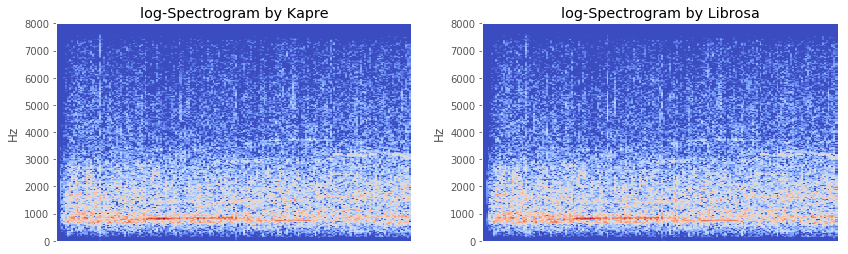

In [48]:
import keras
import kapre
from keras.models import Sequential
from kapre.time_frequency import Spectrogram
import numpy as np
src = np.random.random((1, SR * 3))
model = Sequential()
model.add(Spectrogram(n_dft=512, n_hop=256, input_shape=src.shape, 
          return_decibel_spectrogram=False, power_spectrogram=2.0, 
          trainable_kernel=False, name='static_stft'))

check_model(model)
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.title('log-Spectrogram by Kapre')
visualise_model(model, logam=True)
plt.subplot(1, 2, 2)
display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(src_cute[: SR * 3], 512, 256)) ** 2), 
                         y_axis='linear', sr=SR)
plt.title('log-Spectrogram by Librosa')


In [115]:
#one-hot-encode the data for use with categorical_crossentropy
labels_cata = labels - 769
print labels_cata
labels_cata = to_categorical(labels_cata, num_classes=4)
print labels_cata

[3 2 1 0 0 1 2 3 1 2 0 0 0 3 1 1 0 0 2 0 1 3 3 2 0 3 3 1 3 3 1 0 1 2 2 2 3
 2 0 3 1 2 1 2 3 1 2 0 0 0 3 1 0 2 0 2 1 3 0 2 2 0 2 1 3 3 3 2 0 3 1 3 1 0
 2 1 0 2 2 0 2 3 3 1 0 1 3 1 3 2 1 1 1 2 3 0 1 3 0 2 2 3 0 0 2 1 3 3 3 1 0
 2 1 3 0 3 2 1 3 3 0 1 1 2 3 1 0 0 3 1 0 2 1 1 2 0 3 2 2 2 2 0 1 0 1 0 0 2
 2 1 2 3 0 3 0 0 1 3 2 1 3 2 3 2 3 1 1 3 0 1 1 1 2 3 0 3 0 2 0 3 0 2 0 1 2
 2 3 0 1 3 1 2 2 0 3 1 3 0 0 2 2 1 3 1 1 0 1 3 3 1 1 1 1 3 3 2 3 0 1 2 1 0
 3 0 3 0 0 0 0 2 2 3 1 2 2 2 3 2 0 2 0 3 1 3 3 2 3 3 2 1 3 2 0 1 1 1 2 1 3
 2 3 1 2 0 3 0 2 3 0 2 0 1 1 0 3 0 3 2 2 0 2 1 1 0 2 0 1 0]
[[ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 ..., 
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 1.  0.  0.  0.]]


In [113]:
#vanilla LSTM implementation
model = Sequential()
model.add(LSTM(5, input_shape=(1000, 25), ))
model.add(Dense(4, activation= 'softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(data, labels_cata, nb_epoch=2, batch_size=8, verbose=1, validation_split=0.15)
print(model.summary())

Train on 244 samples, validate on 44 samples
Epoch 1/2
244/244 [==============================] - 35s 145ms/step - loss: nan - acc: 0.2131 - val_loss: nan - val_acc: 0.2500
Epoch 2/2
244/244 [==============================] - 25s 102ms/step - loss: nan - acc: 0.2500 - val_loss: nan - val_acc: 0.2500
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_103 (LSTM)              (None, 5)                 620       
_________________________________________________________________
dense_62 (Dense)             (None, 4)                 24        
Total params: 644
Trainable params: 644
Non-trainable params: 0
_________________________________________________________________
None


In [111]:
model = Sequential()
model.add(LSTM(10, input_shape=(1000,25),return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(10))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(data, labels_cata, nb_epoch=3, batch_size=10, verbose=1, validation_split=0.1)
print(model.summary())

Train on 259 samples, validate on 29 samples
Epoch 1/3
259/259 [==============================] - 74s 284ms/step - loss: nan - acc: 0.2896 - val_loss: nan - val_acc: 0.3448
Epoch 2/3
259/259 [==============================] - 64s 247ms/step - loss: nan - acc: 0.2394 - val_loss: nan - val_acc: 0.3448
Epoch 3/3
259/259 [==============================] - 61s 237ms/step - loss: nan - acc: 0.2394 - val_loss: nan - val_acc: 0.3448


In [99]:
# Reference model
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

data_dim = 16
timesteps = 8
num_classes = 10

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential()
model.add(LSTM(32, return_sequences=True,
               input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(LSTM(32))  # return a single vector of dimension 32
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Generate dummy training data
x_train = np.random.random((1000, timesteps, data_dim))
y_train = np.random.random((1000, num_classes))

# Generate dummy validation data
x_val = np.random.random((100, timesteps, data_dim))
y_val = np.random.random((100, num_classes))

model.fit(x_train, y_train,
          batch_size=64, epochs=10,
          validation_data=(x_val, y_val))

Train on 1000 samples, validate on 100 samples
Epoch 1/10
1000/1000 [==============================] - 10s 10ms/step - loss: 11.6029 - acc: 0.1000 - val_loss: 11.4855 - val_acc: 0.0600
Epoch 2/10
1000/1000 [==============================] - 0s 373us/step - loss: 11.6008 - acc: 0.0960 - val_loss: 11.4851 - val_acc: 0.0900
Epoch 3/10
1000/1000 [==============================] - 0s 372us/step - loss: 11.6005 - acc: 0.0900 - val_loss: 11.4878 - val_acc: 0.0900
Epoch 4/10
1000/1000 [==============================] - 0s 401us/step - loss: 11.6001 - acc: 0.1080 - val_loss: 11.4819 - val_acc: 0.0900
Epoch 5/10
1000/1000 [==============================] - 0s 396us/step - loss: 11.5997 - acc: 0.1140 - val_loss: 11.4861 - val_acc: 0.0900
Epoch 6/10
1000/1000 [==============================] - 0s 401us/step - loss: 11.5991 - acc: 0.1240 - val_loss: 11.4835 - val_acc: 0.0900
Epoch 7/10
1000/1000 [==============================] - 0s 401us/step - loss: 11.5991 - acc: 0.1240 - val_loss: 11.4870 - val

In [62]:
#Check the shape of the model and the inputs
model.summary()
print "Inputs: {}".format(model.input_shape)
print "Outputs: {}".format(model.output_shape)
print "Actual input: {}".format(x_train.shape)
print "Actual output: {}".format(y_train.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 8, 32)             6272      
_________________________________________________________________
lstm_43 (LSTM)               (None, 8, 32)             8320      
_________________________________________________________________
lstm_44 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_27 (Dense)             (None, 10)                330       
Total params: 23,242
Trainable params: 23,242
Non-trainable params: 0
_________________________________________________________________
Inputs: (None, 8, 16)
Outputs: (None, 10)
Actual input: (1000, 8, 16)
Actual output: (1000, 10)
